### Imports

In [1]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

## Leitura do ficheiro

In [2]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

In [3]:
file = data_folder / "QuebrasJuntoInc.xlsx"
QuebrasFinal = pd.read_excel(file)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828.0,"0,0029345","0,0000443","0,0024563",...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549.0,"0,0029335","0,0001770","0,0165009",...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459.0,"0,0192281","0,0002655","0,0359047",...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102.0,"0,0000000","0,0000000","0,0000000",...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731.0,"0,0044221","0,0001549","0,0100377",...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2.0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1.0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1.0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1.0,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [4]:
# Colocar datetime
QuebrasFinal["Data do incidente"] = pd.to_datetime(QuebrasFinal["Data do incidente"])

# Remover colunas desnecessárias
columnsRemove = ['Qualidade de Energia Elétrica', 'Qualidade de Serviço Comercial', 'Fundamentação']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

# Substituir as vírgulas por pontos nas colunas supostamente numéricas
colunas_string = QuebrasFinal.iloc[:, 5:33].select_dtypes(include=['object']).columns
QuebrasFinal[colunas_string] = QuebrasFinal[colunas_string].replace(',', '.', regex=True)

QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828.0,0.0029345,0.0000443,0.0024563,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549.0,0.0029335,0.0001770,0.0165009,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459.0,0.0192281,0.0002655,0.0359047,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102.0,0.0000000,0.0000000,0.0000000,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731.0,0.0044221,0.0001549,0.0100377,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2.0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1.0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1.0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1.0,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [5]:
TT = ""
while (TT != "BT") and (TT != "MT"):
    TT = input("Queres que tipo de Tensão? (BT, MT)")
    print(TT)

QuebrasFinal = QuebrasFinal[QuebrasFinal["Nível de Tensão"] == TT]
QuebrasFinal.drop("Nível de Tensão", axis = 1)

Queres que tipo de Tensão? (BT, MT) MT


MT


,Código do Relatório,Concelho,Data do incidente,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,Escavações,55,828.0,0.0029345,0.0000443,0.0024563,0.2135252,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,Abate De Árvores,163,549.0,0.0029335,0.0001770,0.0165009,0.2134525,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,Deslizamento De Terras,596,3459.0,0.0192281,0.0002655,0.0359047,1.3991121,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,Aves,119,1731.0,0.0044221,0.0001549,0.0100377,0.3217694,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
6,EDPD_2018_JAN_T_7,Idanha-A-Nova,2018-01-11,Abate De Árvores,132,2866.0,0.0075190,0.0003872,0.0245542,0.5471120,...,490.6,1.000000,8.1,12.3,4.6,282.0,321.0,3.8,13.7,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,EDPD_2017_NOV_T_43,Lagos,2017-11-10,Veículos,225,3483.0,0.022504,0.000619,0.027988,1.54,...,148.5,0.105263,16.2,22.0,11.1,42.0,79.0,3.7,9.5,0.0
7286,EDPD_2017_NOV_T_44,Lagos,2017-11-28,Descarga Atmosférica Directa,275,2336.0,0.026811,0.001007,0.071775,1.84,...,148.5,0.105263,18.2,21.0,15.9,52.0,281.0,4.4,10.5,8.4
7287,EDPD_2017_NOV_T_45,Portimão,2017-11-07,Intervenções À Superficie,103,696.0,0.005480,0.000077,0.007421,0.38,...,128.2,0.666667,16.7,20.9,11.2,354.0,124.0,2.8,8.0,0.0
7288,EDPD_2017_NOV_T_46,Ansião,2017-11-08,Abate De Árvores,268,3780.0,0.005028,0.000564,0.020130,0.34,...,272.8,1.000000,10.4,17.0,3.2,4.0,357.0,2.4,8.7,0.0


In [6]:
# Lista das colunas a serem convertidas
colunas_para_converter = ['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)', 
                          'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']

# Converter as colunas para o tipo float
QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')


C:\Users\diogo\AppData\Local\Temp\ipykernel_31092\1100263569.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')


## Estandardizar/Normalizar os dados

In [7]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas

Index(['Duração incidente (min)', 'N.º clientes afetados', 'TIEPI MT (min)',
       'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)',
       'SAIDI BT (min)', 'Dia', 'Mês', 'Ano', 'Densidade Populacional',
       'População Residente', 'Setor Primário', 'Setor Secundário',
       'Setor Terciário', 'Indice de Envelhecimento', 'Rural', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

In [8]:
# # Escolher o que queres
# _ = False

# if _ == True:
#     # Criar o objeto do normalizador Min-Max
#     scaler = MinMaxScaler()
    
#     # Normalizar as colunas numéricas
#     QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# else:
#     # Criar o objeto do estandardizador
#     scaler = StandardScaler()
    
#     # Estandardizar as colunas numéricas
#     QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# # Resultado final
# QuebrasFinal

## Imputação dos dados

In [9]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal.reset_index(drop = True)


C:\Users\diogo\AppData\Local\Temp\ipykernel_31092\3166614405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])


,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828.0,0.002935,0.000044,0.002456,...,157.9,0.000000,10.7,17.4,2.6,198.866937,227.938675,3.013693,10.072288,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549.0,0.002933,0.000177,0.016501,...,260.2,1.000000,10.6,13.8,6.2,249.000000,270.000000,2.800000,8.100000,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459.0,0.019228,0.000266,0.035905,...,117.9,0.800000,14.0,14.8,12.9,197.000000,180.000000,3.900000,14.400000,4.0
3,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731.0,0.004422,0.000155,0.010038,...,467.9,1.000000,4.9,7.8,2.2,137.000000,118.000000,4.100000,15.400000,15.9
4,EDPD_2018_JAN_T_7,Idanha-A-Nova,2018-01-11,MT,Abate De Árvores,132.0,2866.0,0.007519,0.000387,0.024554,...,490.6,1.000000,8.1,12.3,4.6,282.000000,321.000000,3.800000,13.700000,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3406,EDPD_2017_NOV_T_43,Lagos,2017-11-10,MT,Veículos,225.0,3483.0,0.022504,0.000619,0.027988,...,148.5,0.105263,16.2,22.0,11.1,42.000000,79.000000,3.700000,9.500000,0.0
3407,EDPD_2017_NOV_T_44,Lagos,2017-11-28,MT,Descarga Atmosférica Directa,275.0,2336.0,0.026811,0.001007,0.071775,...,148.5,0.105263,18.2,21.0,15.9,52.000000,281.000000,4.400000,10.500000,8.4
3408,EDPD_2017_NOV_T_45,Portimão,2017-11-07,MT,Intervenções À Superficie,103.0,696.0,0.005480,0.000077,0.007421,...,128.2,0.666667,16.7,20.9,11.2,354.000000,124.000000,2.800000,8.000000,0.0
3409,EDPD_2017_NOV_T_46,Ansião,2017-11-08,MT,Abate De Árvores,268.0,3780.0,0.005028,0.000564,0.020130,...,272.8,1.000000,10.4,17.0,3.2,4.000000,357.000000,2.400000,8.700000,0.0


In [10]:
QuebrasFinal[QuebrasFinal.isna().any(axis=1)]

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD


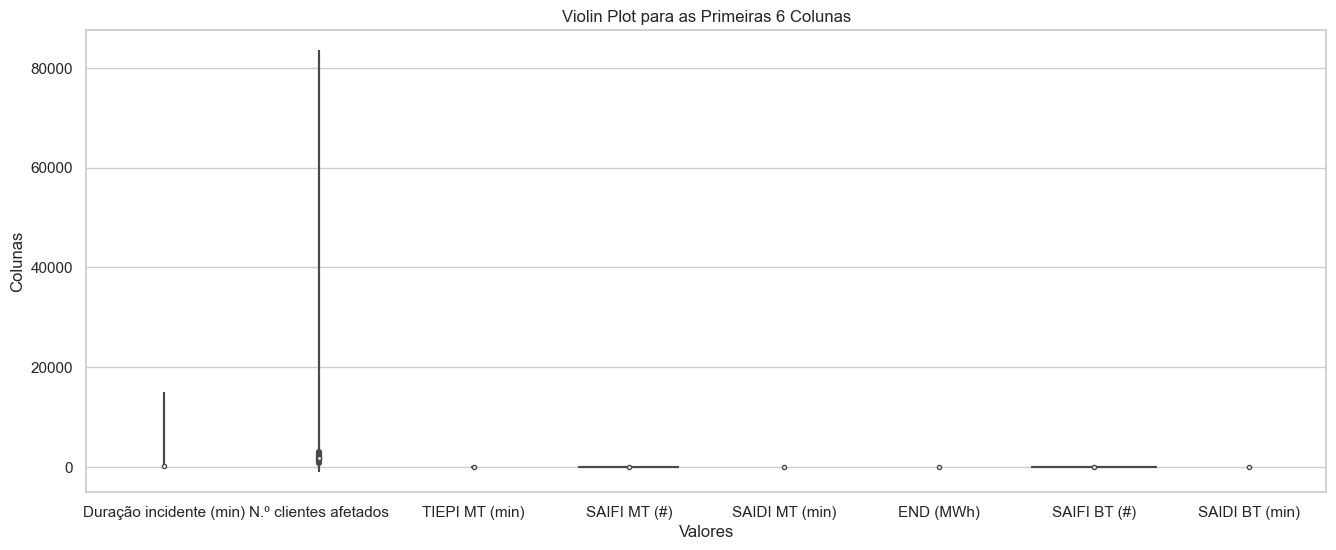

In [11]:
sns.set(style="whitegrid")

# Selecionar apenas as primeiras 6 colunas
subset_quebras_final = QuebrasFinal.iloc[:, 5:13]

# Plotar violin plot para as primeiras 6 colunas
plt.figure(figsize=(16, 6))
sns.violinplot(data=subset_quebras_final)
plt.title("Violin Plot para as Primeiras 6 Colunas")
plt.xlabel("Valores")
plt.ylabel("Colunas")
plt.show()

In [12]:
QuebrasFinal["Causa do incidente"].unique()

array(['Escavações', 'Abate De Árvores', 'Deslizamento De Terras', 'Aves',
       'Animais Não Aves', 'Malfeitoria/Vandalismo', 'Veículos',
       'Terramoto', 'Neve/Gelo/Granizo Condição Excecional',
       'Corpos Estranhos Na Rede', 'Vento Intensidade Excepcional',
       'Descarga Atmosférica Directa', 'Intervenções À Superficie',
       'Inundações Imprevisíveis', 'Risco Iminente Pessoas Ou Bens',
       'Incêndio', 'Furtos', 'Sabotagem',
       'Desabamento De Muros/Outras Cons',
       'Desabamento De Muros/Outras Construções',
       'Trabalhos De Terceiros ( Gruas,... )'], dtype=object)

## _Fogo_ --

In [13]:
CausaEstudo = 'Incêndio'

In [14]:
Visualizar = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[['TIEPI MT (min)', 'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']].mean().reset_index()
Visualizar

,Dia,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),SAIDI BT (min),T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,2.0,0.041395,0.000711,0.077240,2.884299,0.000572,0.056977,21.200000,27.900000,14.300000,10.000000,13.000000,2.000000,8.300000,0.000000
1,3.0,0.379200,0.002100,0.957100,24.875200,0.001200,0.885800,30.400000,36.000000,24.500000,86.000000,79.000000,5.300000,13.100000,0.000000
2,4.0,0.010839,0.000329,0.018931,0.723333,0.000251,0.011228,20.196247,27.566131,13.809455,255.000000,274.000000,2.700000,9.300000,0.466667
3,5.0,0.007942,0.000340,0.023372,0.579496,0.000259,0.016187,26.000000,33.366667,19.133333,172.000000,203.666667,2.766667,9.833333,0.000000
4,6.0,0.010980,0.000473,0.038764,0.740840,0.000339,0.027364,24.733333,35.433333,17.600000,232.371788,245.986547,2.367060,9.558456,0.000000
5,7.0,0.008688,0.000227,0.020158,0.622481,0.000116,0.010126,25.050000,32.575000,18.725000,193.255342,198.859624,3.667757,10.720368,0.000000
6,8.0,0.006114,0.000346,0.021105,0.402000,0.000202,0.013443,22.540000,31.520000,14.980000,251.824154,269.350331,2.718019,9.662449,0.000000
7,9.0,0.001952,0.000089,0.007947,0.130000,0.000039,0.004925,18.600000,24.600000,13.200000,305.000000,321.000000,5.200000,15.700000,0.000000
8,10.0,0.012411,0.000370,0.028984,0.818750,0.000279,0.017601,21.900000,29.962500,14.950000,283.466039,249.776077,3.016240,9.524526,0.000000
9,11.0,0.004415,0.000234,0.017284,0.315396,0.000146,0.010497,20.300000,29.150000,14.000000,197.500000,239.000000,3.150000,10.650000,0.000000


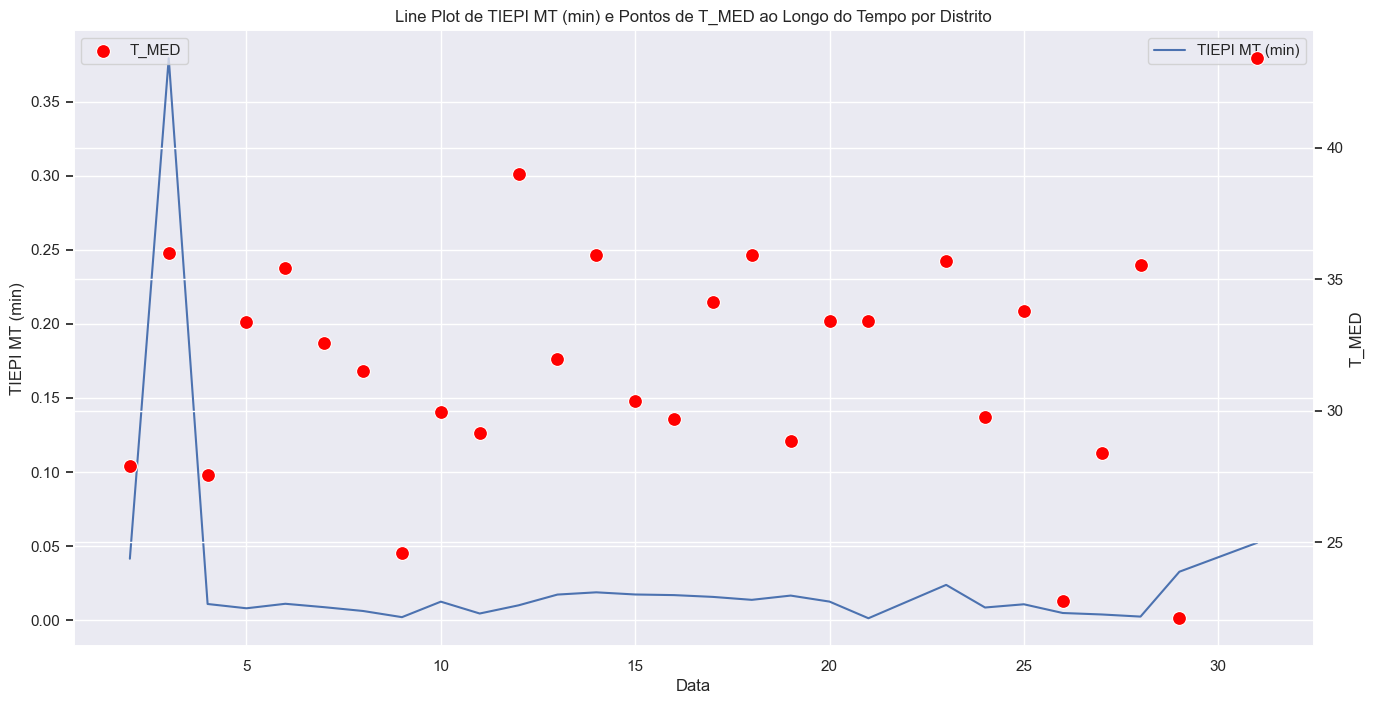

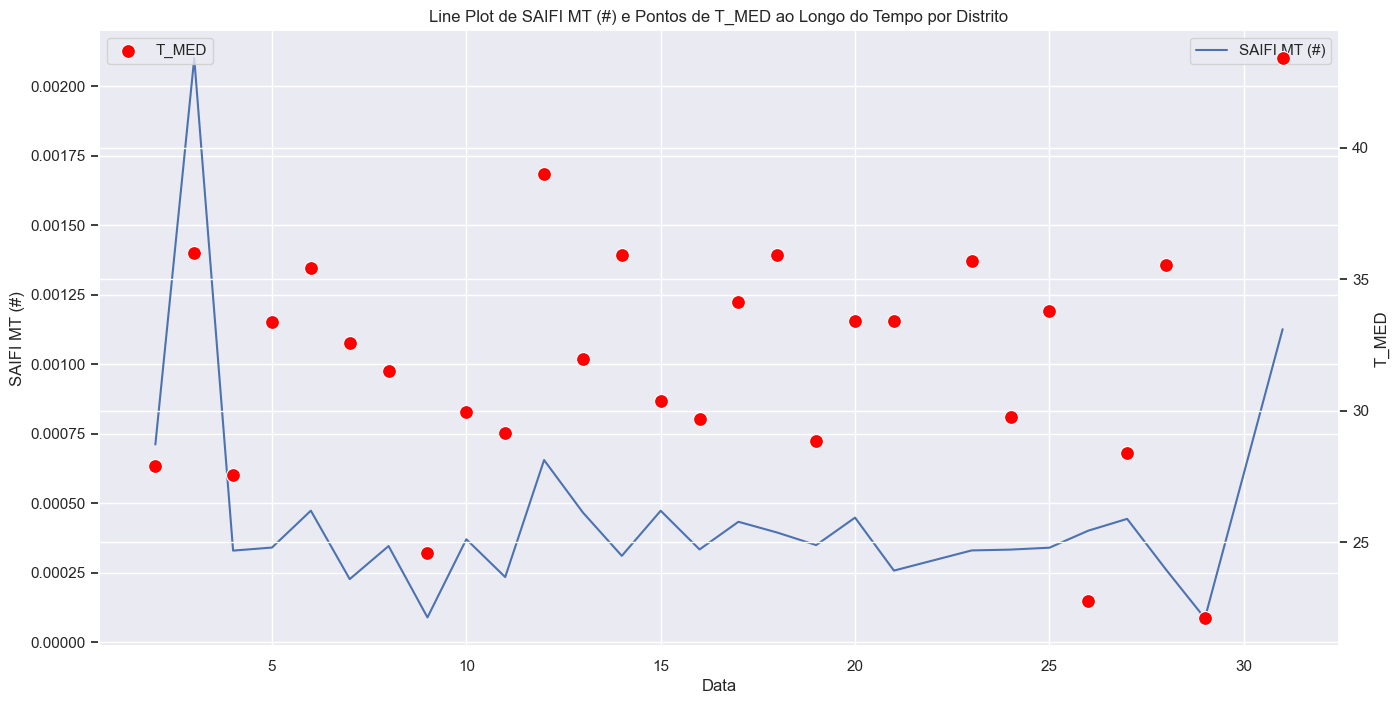

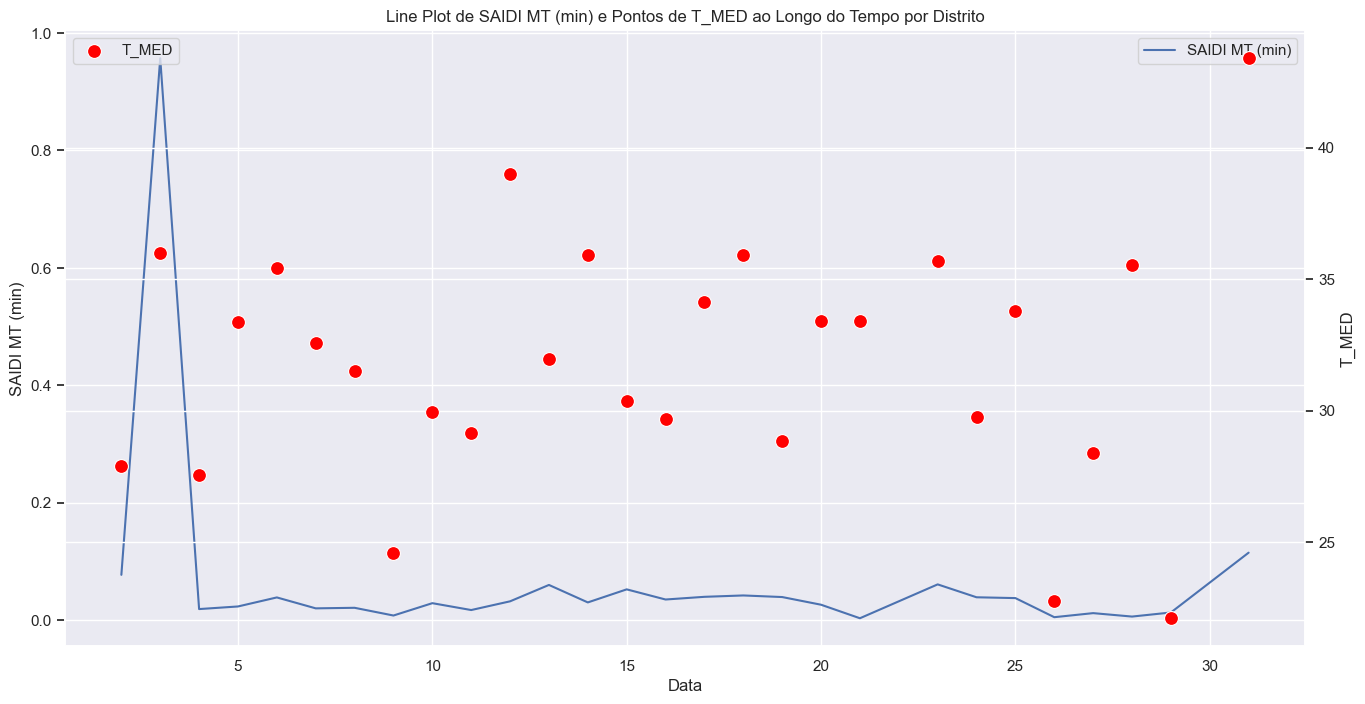

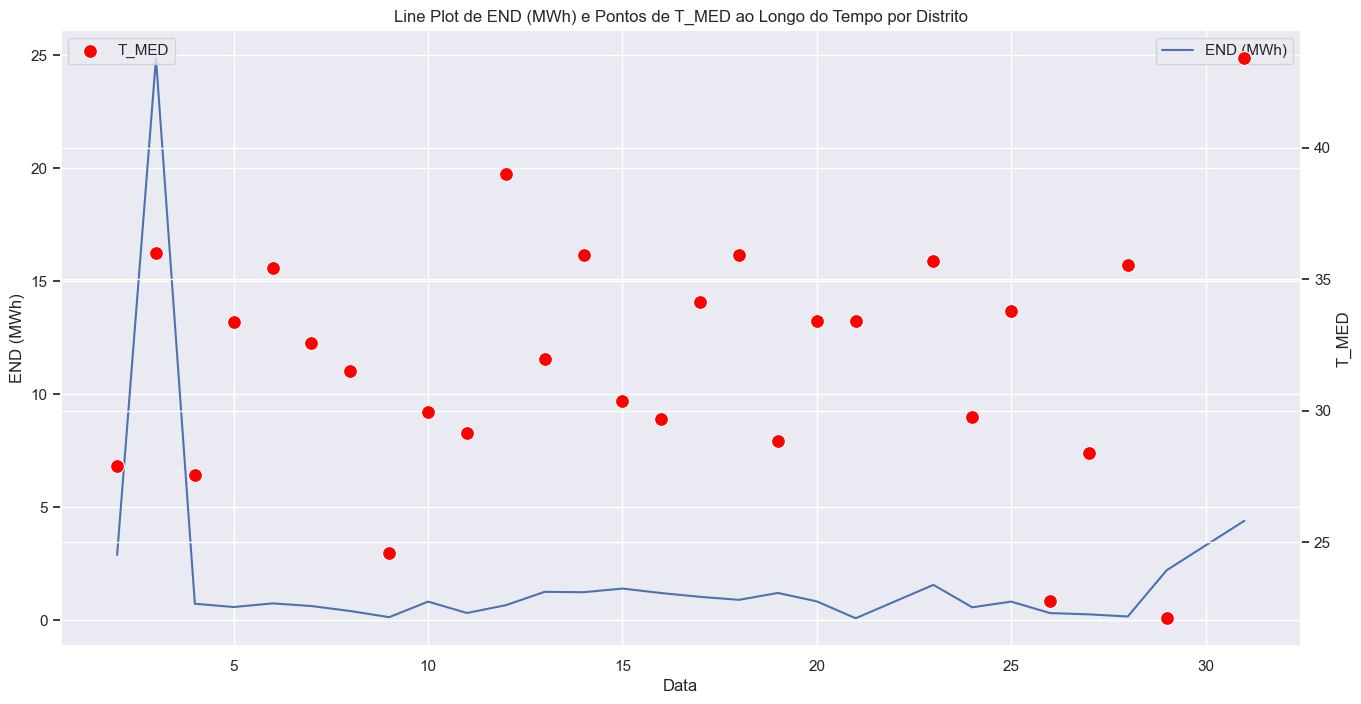

In [32]:
# Converter 'Dia' para numérico
Visualizar['Dia'] = Visualizar['Dia'].astype(int)

if TT == "BT":
    variaveis = ['SAIFI BT (#)', 'SAIDI BT (min)']
else:
    variaveis = ["TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)", "END (MWh)"]

# Definir o estilo do Seaborn
sns.set_style("darkgrid")

# Loop sobre as variáveis
for i in variaveis:
    # Criar o line plot para 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)'
    plt.figure(figsize=(16, 8))
    ax1 = sns.lineplot(data=Visualizar, x='Dia', y=i, markers=True, dashes=False, label=i)
    
    # Adicionar pontos para 'T_MED' em cada dia
    ax2 = ax1.twinx()
    sns.scatterplot(data=Visualizar, x='Dia', y='T_MAX', color='red', s=100, ax=ax2, label='T_MED')
    
    # Adicionar título e etiquetas dos eixos
    plt.title(f'Line Plot de {i} e Pontos de T_MED ao Longo do Tempo por Distrito')
    ax1.set_xlabel('Data')
    ax1.set_ylabel(i)
    ax2.set_ylabel('T_MED')
    
    # Mostrar o gráfico
    plt.show()


## _Descarga Atmosférica Directa_ --

In [33]:
CausaEstudo = 'Descarga Atmosférica Directa'

In [34]:
Visualizar = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[['TIEPI MT (min)', 'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']].mean().reset_index()
Visualizar

,Dia,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),SAIDI BT (min),T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,1.0,0.016265,0.000394,0.047620,1.129729,0.000305,0.034349,17.430769,24.392308,13.846154,267.914075,157.350823,2.572284,8.883493,10.715385
1,2.0,0.011718,0.000737,0.031508,0.507634,0.001858,0.020188,14.350000,20.583333,10.483333,118.346694,195.668362,1.950000,9.016667,4.515887
2,3.0,0.023690,0.000371,0.060208,1.656018,0.000260,0.049286,19.891667,26.316667,15.966667,114.956151,226.609805,1.850000,8.583333,4.060037
3,4.0,0.012274,0.000233,0.032700,0.907664,0.000151,0.022882,15.900000,22.480000,10.160000,227.800000,238.400000,3.980000,14.500000,20.620000
4,5.0,0.019895,0.000435,0.046893,1.394046,0.000310,0.030289,17.587500,23.712500,13.543750,208.562500,243.062500,2.243750,10.093750,5.022035
5,6.0,0.018196,0.000580,0.045168,1.247564,0.000397,0.030234,17.063482,24.473587,12.007922,249.600000,177.800000,2.706012,14.892639,11.540000
6,7.0,0.019894,0.000449,0.042884,1.294427,0.000324,0.029163,19.512500,26.087500,14.150000,207.875000,251.500000,1.975000,8.725000,7.237500
7,8.0,0.016521,0.000364,0.032777,1.113253,0.000317,0.027297,19.967734,27.008718,15.515000,263.342892,234.403134,2.156167,9.979386,4.249130
8,9.0,0.008344,0.000602,0.022948,0.584564,0.000419,0.016272,13.300000,18.000000,9.033333,199.000000,272.666667,2.233333,10.100000,21.100000
9,10.0,0.017799,0.000358,0.042813,1.414623,0.000280,0.026337,22.700000,31.066667,18.000000,108.333333,260.666667,2.566667,11.233333,7.366667


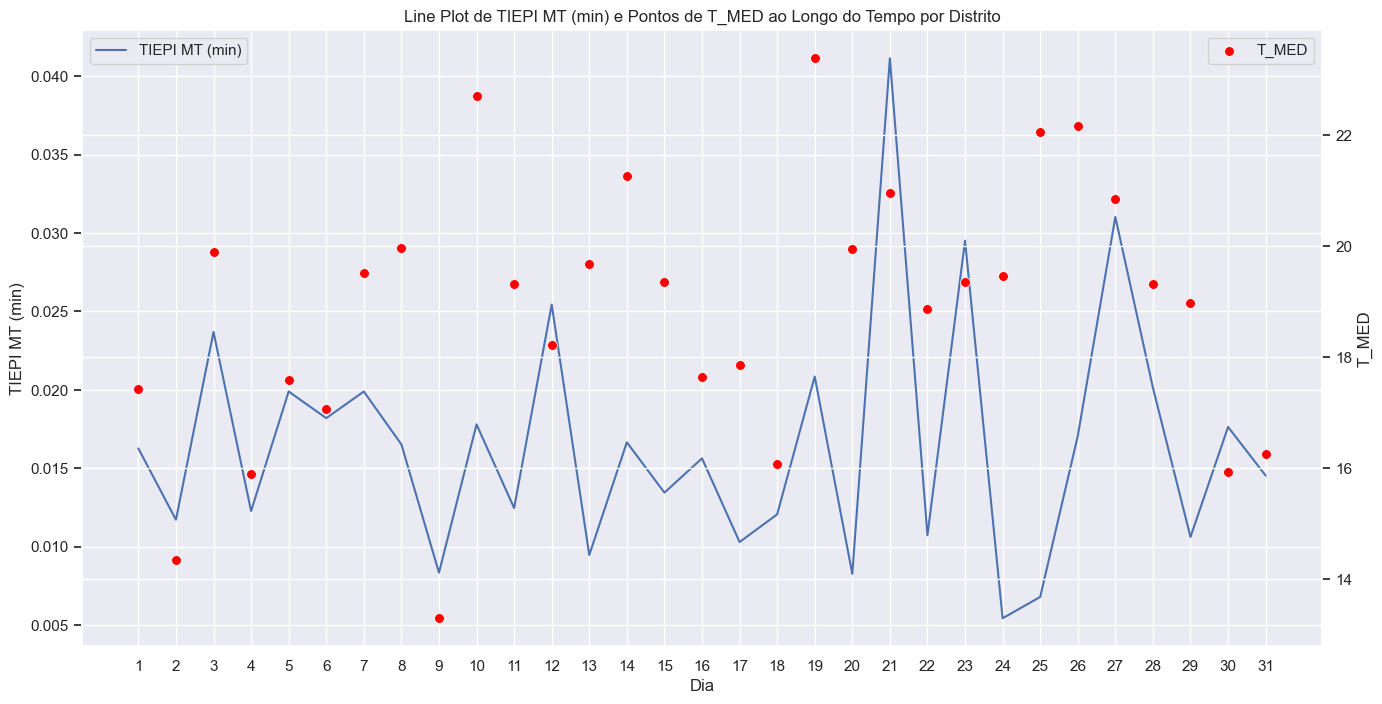

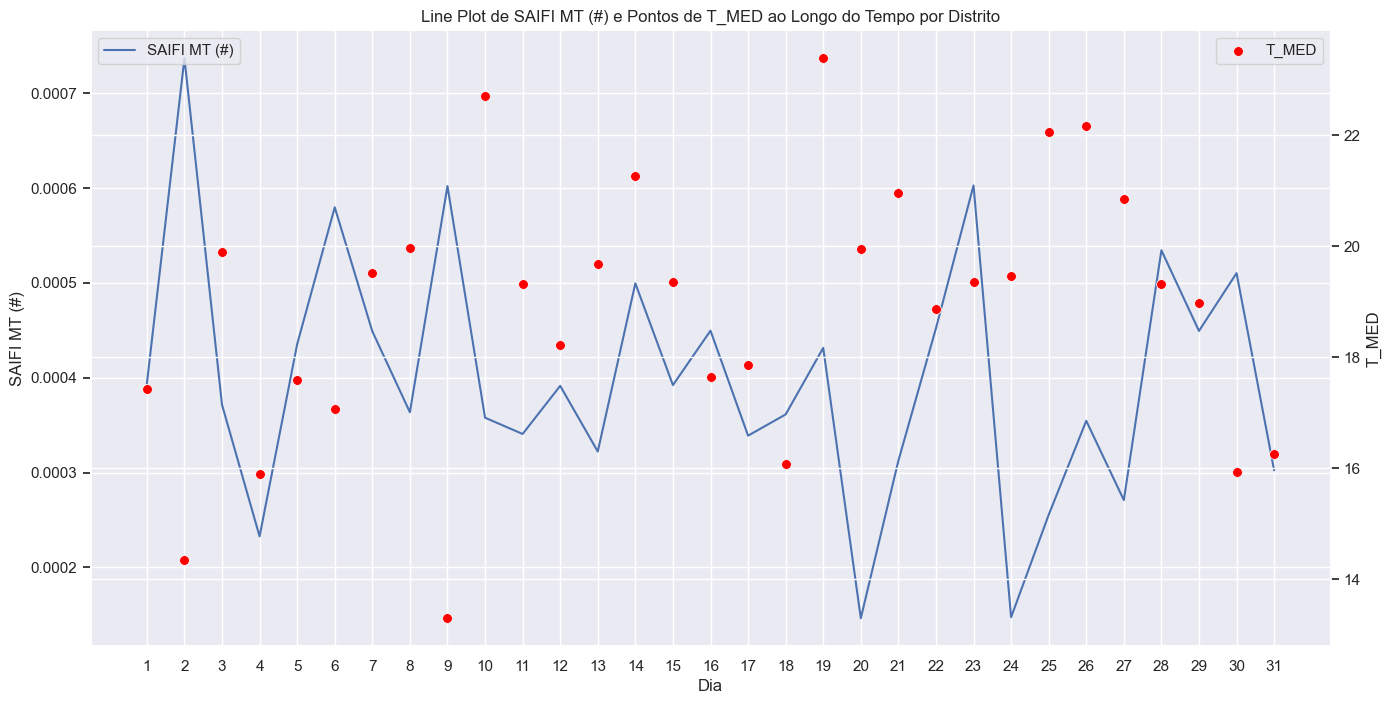

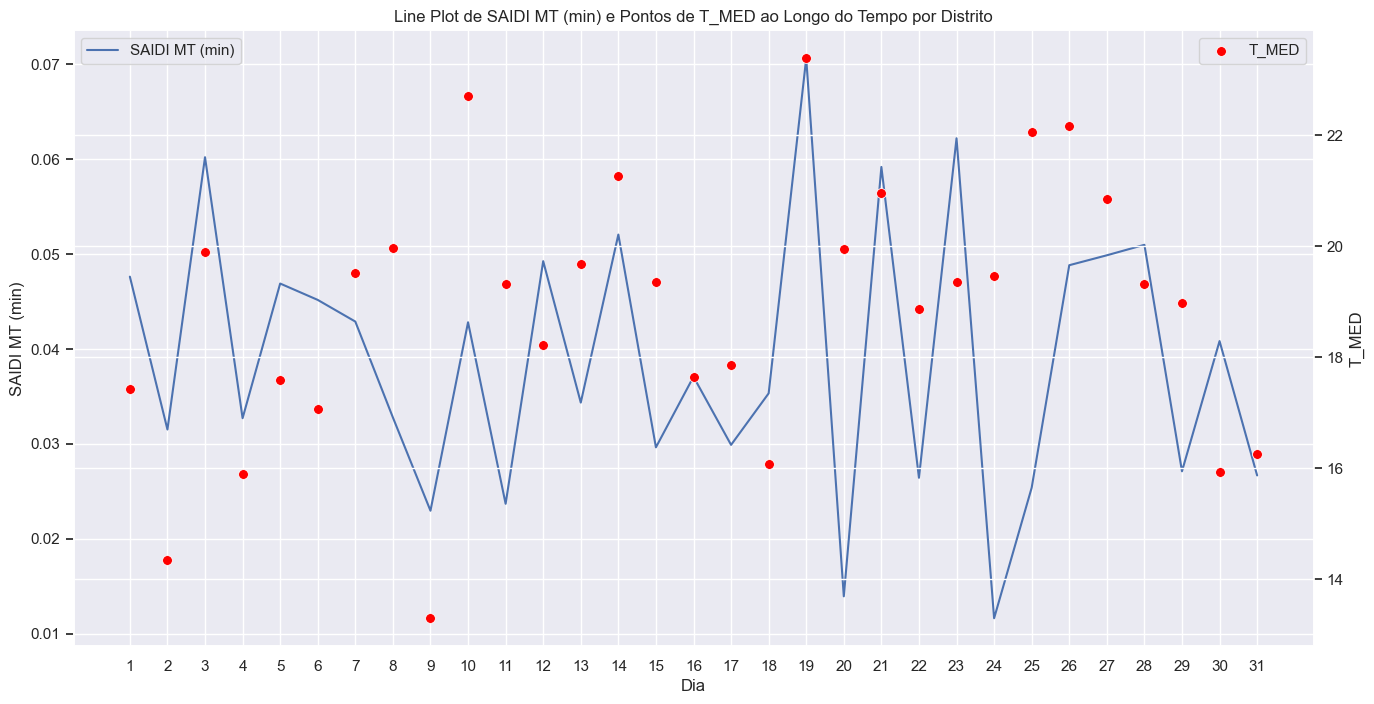

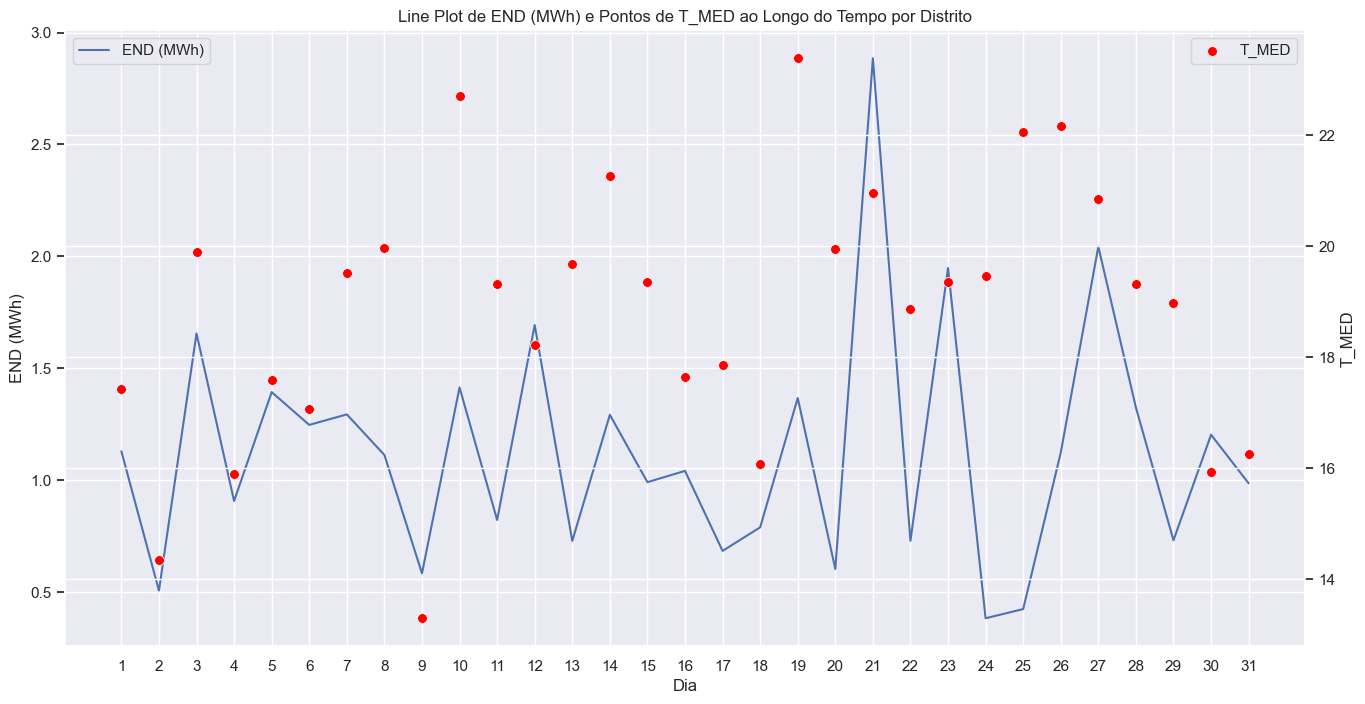

In [96]:
# Converter 'Dia' para numérico
Visualizar['Dia'] = Visualizar['Dia'].astype(int)

# Obter todos os dias do intervalo
todos_os_dias = range(Visualizar['Dia'].min(), Visualizar['Dia'].max() + 1)

if TT == "BT":
    variaveis = ['SAIFI BT (#)', 'SAIDI BT (min)']
else:
    variaveis = ["TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)", "END (MWh)"]

# Definir o estilo do Seaborn
sns.set_style("darkgrid")
tips = sns.load_dataset('tips')
sns.set_context('notebook', font_scale = 1)

IPMA = "T_MED"

# Loop sobre as variáveis
for i in variaveis:
    # Criar o line plot para 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)'
    plt.figure(figsize=(16, 8))
    ax1 = sns.lineplot(data=Visualizar, x='Dia', y=i, label=i, dashes=False, markers=True)

    # Adicionar legenda à esquerda
    plt.legend(loc='upper left')
    
    # Adicionar pontos para 'T_MED' em cada dia
    ax2 = ax1.twinx()
    sns.scatterplot(data=Visualizar, x='Dia', y=IPMA, color='red', s=50, ax=ax2, label=IPMA)

    # Definir todos os dias no eixo x
    plt.xticks(todos_os_dias)
    
    # Adicionar título e etiquetas dos eixos
    plt.title(f'Line Plot de {i} e Pontos de T_MED ao Longo do Tempo por Distrito')
    ax1.set_xlabel('Dia')
    ax1.set_ylabel(i)
    ax2.set_ylabel(IPMA)
    
    # Mostrar o gráfico
    plt.show()
